In [32]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn
import scipy.stats as stt
seaborn.set(font_scale=1.5,style='ticks')
import os
import re
import sys
import itertools
import functools
import networkx as nx
from datetime import date, timedelta
from datetime import datetime

#sys.path.append(r"C:\Users\yweissenberger\Documents\code\line_loop-master")
#sys.path.append(r"C:\Users\yweissenberger\Documents\code\line_loop-master\packages")
sys.path.append("/Users/joshuakeeling/Documents/Python/Project/line_loop/packages/")

In [33]:
import mouse_poker as mpk
from mouse_poker.navi import *

In [108]:
def performance_arrays(state_seq,port_seq,rew_list,forced_seq):
    
    """
    Find the state being rewarded during each step in the session
    If the choice that is made decreases the step distance from rew
    score choice as correct (1) if not, score as incorrect (0)
    
    Creates some useful arrays: 
    state_seq,rew_list,port_seq,forced_seq,rew_state,score_list,
    rew_change,rew_change_end,trial_perf,trial_rew_change_end
    """
    
    ##Need to end the used data with the final reward rather than 
    #half way through a trial
    #take out forced trials
    final = np.where(rew_list)[0][-1]+1
    state_seq = state_seq[0:final]
    rew_list = rew_list[0:final]
    port_seq = port_seq[0:final]
    forced_seq = forced_seq[0:final]    
    
    ##Create array of state being rewarded during each step in the session
    rew_state = np.zeros(len(rew_list))
    prev_rew_ind = 0
    for rew_ind in np.where(rew_list)[0]:
        rew_state[prev_rew_ind:rew_ind+1]=state_seq[rew_ind]
        prev_rew_ind = rew_ind+1

    #Whether the choice is correct:
    score_list = np.zeros(len(rew_list))

    for state_ind in np.arange(len(state_seq)):
        if rew_list[state_ind] is True:
            score_list[state_ind] = 'Nan' #Score the reward state "choice" as Nan
        else:
            d0 = np.abs(state_seq[state_ind]-rew_state[state_ind])
            d1 = np.abs(state_seq[state_ind+1]-rew_state[state_ind+1])
            if d1 - d0 == -1:
                #correct choice gets score of 1
                score_list[state_ind]=1
            else:
                #incorrect choice gets score of 0
                score_list[state_ind]=0
    
    ##Remove forced choices from performance scores
    score_list[np.where(forced_seq)[0]]='Nan'
    
    ##Remove end of line choices from performance scores if "line"
    if mpk.load.get_metadata(lines)[5]=='line':
        ind = np.where((np.array(state_seq)==min(state_seq))|(np.array(state_seq)==max(state_seq)))[0]
        score_list[ind]='Nan'
        
    ##Arr for indices of reward changes
    rew_change = np.where(rew_state[:-1] != rew_state[1:])[0]
    #Ensure analysis of final section
    rew_change_end = np.append(rew_change, len(rew_list)-1)
    
    ## Arr of perf with each successive trial
    # trial_perf
    rew_ind = np.where(rew_list)[0]
    trial_perf = [] #Arr w perf on each trial scored as above
    low1 = -1
    low2 = 0

    for rew_change_ind in rew_change_end:
        for trial_ind in np.where((rew_ind>low1) & (rew_ind<=rew_change_ind))[0]:
            upp = int(rew_ind[trial_ind])
            y = np.nanmean(score_list[low2:upp])
            low2 = int(rew_ind[trial_ind])
            trial_perf.append(y)
        low1 = rew_change_ind

    ##Create arr for trial# where rew change
    # trial_rew_change_end
    trial_rew_change_end = np.zeros(len(rew_change_end))
    for rew_change_step in np.arange(len(rew_change_end)):
        y = np.where(np.where(rew_list)[0]==rew_change_end[rew_change_step])[0]
        trial_rew_change_end[rew_change_step] = y 


    return state_seq,rew_list,port_seq,forced_seq,rew_state,score_list,\
rew_change,rew_change_end,trial_perf,trial_rew_change_end


def get_poke_to_state_map(lines):
    """ """
    tmp = []
    for i,j in zip([int(re.findall('POKEDPORT_([0-9])',i)[0]) for i in lines if '_POKEDPORT' in i],
                         [int(re.findall('POKEDSTATE_([0-9])',i)[0]) for i in lines if '_POKEDSTATE' in i]):

        if [i,j] not in tmp:
            tmp.append([i,j])
    poke_to_state_map = [i[1] for i in sorted(tmp)]
    return poke_to_state_map

In [166]:
rew_ind = np.where(rew_list)[0]
trial_perf = [] #Arr w perf on each trial scored as above
low1 = -1
low2 = 0

for rew_change_ind in rew_change_end:
        for trial_ind in np.where((rew_ind>low1) & (rew_ind<=rew_change_ind))[0]:
            upp = int(rew_ind[trial_ind])
            y = np.nanmean(score_list[low2:upp])
            low2 = int(rew_ind[trial_ind])
            trial_perf.append(y)
        low1 = rew_change_ind

<ipython-input-166-0687ffb4d87b>:9: RuntimeWarning: Mean of empty slice
  y = np.nanmean(score_list[low2:upp])


In [168]:
#Need to check for disparity between trial number and trial number where rew loc changes

#why is trial_perf first value nan

221

In [148]:
##BATCH ANALYSIS:

#ROOT = '/Users/joshuakeeling/Documents/Python/Project/beh_data_newroom/line_loop_batch_3NAVI/'
ROOT = '/Users/joshuakeeling/Documents/Python/Project/beh_data_newroom/line_loop_batch_4_RUNNAVI/'

res_dict = {}
minNrew = 100
today = datetime.now()

files = []
DF = pd.DataFrame()

for filename in os.listdir(ROOT):
    if filename.endswith(".txt"): 
        files.append(filename)
    else:
        continue

for file in files:
    
    fpath = os.path.join(ROOT, file)
    f = open(fpath, 'r')
    lines = f.readlines()
    
    #Get metadata:
    experiment_name, task_name, subject_id, task_nr, graph,lineloop,date,\
        test,overview = mpk.load.get_metadata(lines)
    
    
    if overview['n_rewards'] > minNrew:
        
        state_seq,rew_list,port_seq,forced_seq = extract_navi_dat(lines)

        state_seq,rew_list,port_seq,forced_seq,rew_state,score_list,\
            rew_change,rew_change_end,trial_perf,trial_rew_change_end \
            = performance_arrays(state_seq,port_seq,rew_list,forced_seq)
        
        poke_state_map = get_poke_to_state_map(lines)
   
        file_dict = {'subject_id':subject_id,'date_time':pd.to_datetime(date),\
                'state_seq':state_seq,'rew_list':rew_list,'port_seq':port_seq,\
                'forced_seq':forced_seq,'rew_state':rew_state,'score_list':score_list,\
                'rew_change':rew_change,'rew_change_end':rew_change_end,\
                'trial_perf':trial_perf,'trial_rew_change_end':trial_rew_change_end,\
                'poke_state_map':poke_state_map}

        DF = DF.append(file_dict, ignore_index = True)
    
        mean_perf = np.nanmean(score_list)

        print(mpk.load.get_metadata(lines)[5], int(100*mean_perf), file)

line 78 '456675_3'-2021-03-02-103339.txt
line 68 '456675_3'-2021-02-15-113953.txt
line 70 '456675_3'-2021-02-23-102808.txt
line 69 '456675_3'-2021-02-25-110427.txt


<ipython-input-108-dcc0276df9f4>:68: RuntimeWarning: Mean of empty slice
  y = np.nanmean(score_list[low2:upp])


line 56 '456675_3'-2021-03-05-120244.txt
line 69 '456675_3'-2021-03-01-110336.txt
line 79 '456675_3'-2021-03-04-105909.txt
line 69 '456675_3'-2021-02-12-121633.txt
line 82 '456675_3'-2021-03-03-105842.txt
line 65 '456675_3'-2021-02-11-122740.txt
line 76 '456675_3'-2021-02-26-104433.txt


In [ ]:
list(zip(rew_list,rew_state))[497]

In [99]:
rew_change_end

array([ 174,  321,  496,  762,  862, 1152, 1395, 1554, 1623])

array([5., 5., 5., ..., 7., 7., 7.])

In [93]:
(DF['rew_change_end'])

0     [162, 450, 548, 676, 834, 998, 1106, 1294, 144...
1                            [336, 602, 707, 965, 1081]
2                 [184, 428, 653, 754, 982, 1204, 1404]
3                      [323, 517, 752, 866, 1033, 1239]
4               [128, 504, 723, 1032, 1499, 1716, 1798]
5                            [193, 323, 549, 890, 1010]
6     [191, 326, 437, 611, 738, 993, 1091, 1230, 133...
7               [315, 703, 892, 1243, 1456, 1593, 1712]
8            [166, 260, 536, 656, 827, 924, 1149, 1275]
9                           [517, 712, 830, 1021, 1193]
10    [174, 321, 496, 762, 862, 1152, 1395, 1554, 1623]
Name: rew_change_end, dtype: object

In [51]:
x = 1554

print(rew_state[x-4:x+7])
print(score_list[x-4:x+7])
print(state_seq[x-4:x+7])

[3. 3. 3. 3. 3. 7. 7. 7. 7. 7. 7.]
[ 0.  1.  1.  1. nan  1.  0.  0.  0.  0.  1.]
[5, 6, 5, 4, 3, 5, 6, 5, 4, 3, 2]


In [94]:
trial_rew_change_end

array([ 23.,  50.,  73.,  96., 119., 143., 178., 213., 220.])

In [70]:
np.unique(DF['rew_state'][8])

array([1., 3., 5.])

In [19]:
#Performance in each state for a given reward location

min_state = np.min(DF['state_seq'][0]) #uses values from the first session for all sessions
max_state = np.max(DF['state_seq'][0]) #uses values from the first session for all sessions
rew_locs = (np.unique(DF['rew_state'][0])).astype(int) #uses values from the first session for all sessions 

Ncols = len(np.arange(min_state,max_state+1,1))
Nrows = len(np.unique(rew_locs))
Nsess = len(np.arange(np.shape(DF)[0]))

score_matrix = np.zeros((Nsess,Nrows,Ncols))
count_matrix = np.zeros((Nsess,Nrows,Ncols))

for sess in np.arange(np.shape(DF)[0]):
    STATE = DF['state_seq'][sess]
    SCORE = DF['score_list'][sess]
    REW_LOC = (DF['rew_state'][sess]).astype(int)
    
    for col in np.arange(min_state,max_state+1,1):
        for rew_loc in rew_locs:
            
            score_sum = np.nansum(((SCORE[np.where((np.array(STATE)==col)&(np.array(REW_LOC)==rew_loc))[0]])))
            count = sum(~np.isnan(SCORE[np.where((np.array(STATE)==col)&(np.array(REW_LOC)==rew_loc))[0]]))
            row = np.where(rew_locs==rew_loc)[0]
            score_matrix[sess,row,col] = score_sum
            count_matrix[sess,row,col] = count
            
score_matrix = np.sum(score_matrix, axis = 0)/np.sum(count_matrix, axis = 0)

<ipython-input-19-caa6935def0a>:28: RuntimeWarning: invalid value encountered in true_divide
  score_matrix = np.sum(score_matrix, axis = 0)/np.sum(count_matrix, axis = 0)


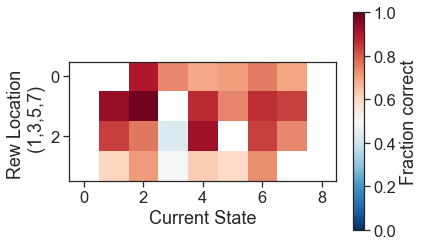

In [20]:
#Plot of performance with given reward locations

plt.imshow(score_matrix,vmin=0,vmax=1,cmap='RdBu_r')
plt.xlabel("Current State")
plt.ylabel("Rew Location \n (1,3,5,7)")
cbar = plt.colorbar()
cbar.set_label("Fraction correct")

In [21]:
#Performance across sessions 

min_state = np.min(DF['state_seq'][0])
max_state = np.max(DF['state_seq'][0])


Ncols = len(np.arange(min_state,max_state+1,1))
Nrows = np.shape(DF)[0]
empty = np.zeros((Nrows,Ncols))

for row in np.arange(np.shape(DF)[0]):
    
    STATE = DF['state_seq'][row]
    SCORE = DF['score_list'][row]
    
    for col in np.arange(np.min(STATE),np.max(STATE)+1,1):
        y = np.nanmean(SCORE[np.where(np.array(STATE)==col)[0]])
        empty[row,col] = y


<ipython-input-21-3662b4d4db37>:17: RuntimeWarning: Mean of empty slice
  y = np.nanmean(SCORE[np.where(np.array(STATE)==col)[0]])


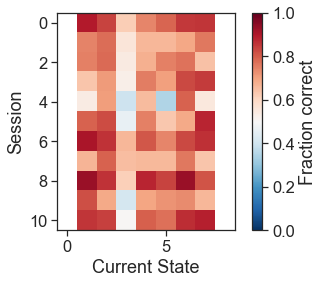

In [22]:
#Plot of performance across sessions 

plt.imshow(empty,vmin=0,vmax=1,cmap='RdBu_r')
plt.xlabel("Current State")
plt.ylabel("Session")
cbar = plt.colorbar()
cbar.set_label("Fraction correct")

In [23]:
#Need to work out logic gate for trial selection
#IF N is the trial with a new reward location (rew location is discovered this trial)
#need to look at N + 1 and see if the mouse goes towards the old rew location or the new one
#can only test this when on trial N+1 the mouse is started between the old and new rew location in state space


In [24]:
##SINGLE FILE ANALYSIS

#This one for 3:
root = '/Users/joshuakeeling/Documents/Python/Project/beh_data_newroom/line_loop_batch_3NAVI/'
#file = "'456675_10'-2021-02-23-102809.txt"
#file = "'456675_10'-2021-03-04-105905.txt"
file = "'460175_10'-2021-03-02-142443.txt"
#file = "'460175_10'-2021-03-02-132053.txt"

# #This one for 4:
# root = '/Users/joshuakeeling/Documents/Python/Project/beh_data_newroom/line_loop_batch_4_RUNNAVI/'
# #file = "'456675_3'-2021-02-12-121633.txt"
# file = "'456675_3'-2021-03-02-103339.txt"

fpath = os.path.join(root,file)
f = open(fpath)
lines = f.readlines()

#Get metadata:
experiment_name, task_name, subject_id, task_nr, graph,lineloop,date,\
    test,overview = mpk.load.get_metadata(lines)

state_seq,rew_list,port_seq,forced_seq = extract_navi_dat(lines)

overview

state_seq,rew_list,port_seq,forced_seq,rew_state,score_list,\
rew_change,rew_change_end,trial_perf,trial_rew_change_end \
= performance_arrays(state_seq,port_seq,rew_list,forced_seq)

0.7744545077132459


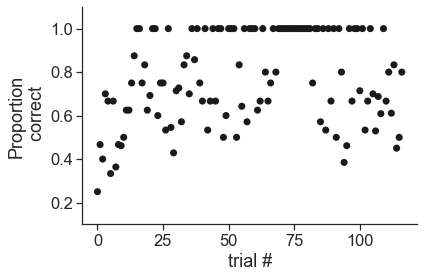

0.7974351387535118


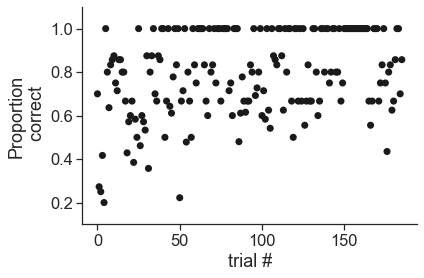

0.8001233017974089


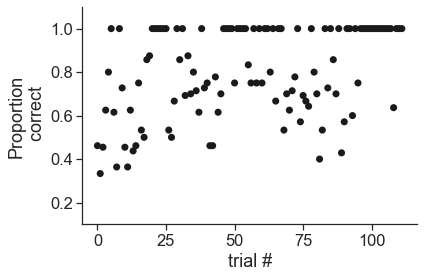

0.80550185842102


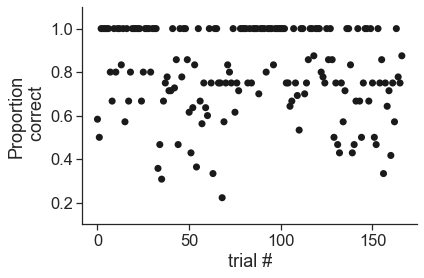

0.7844977938727938


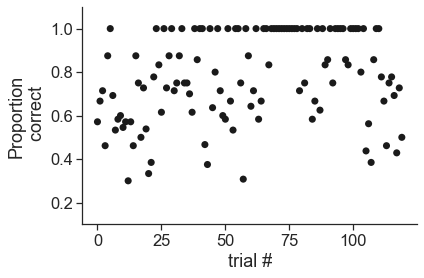

0.8650571839776386


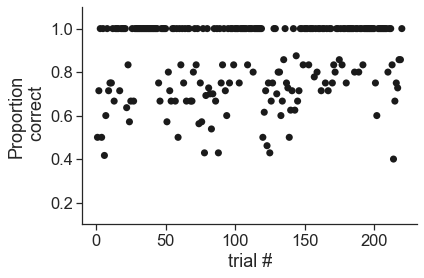

0.8153356377715353


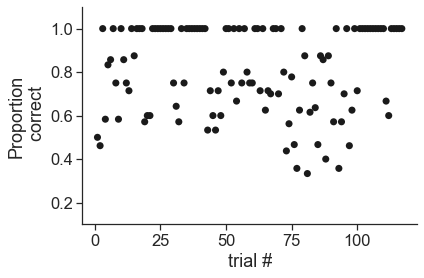

0.8821616331696976


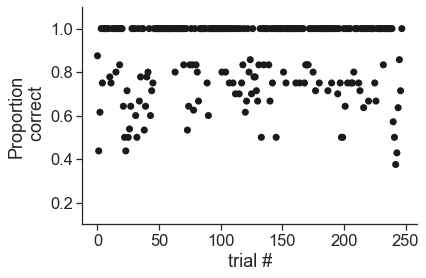

0.8942043927596691


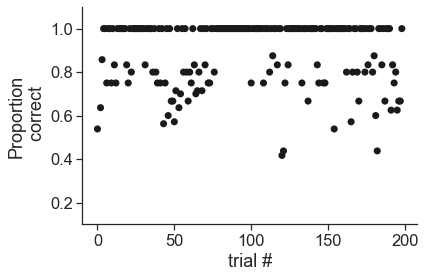

0.8896544245228456


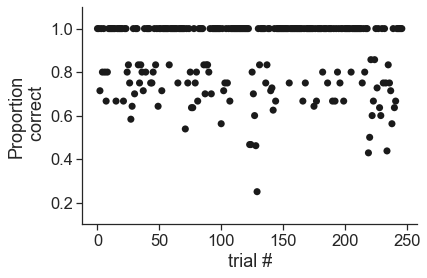

0.6762772829674236


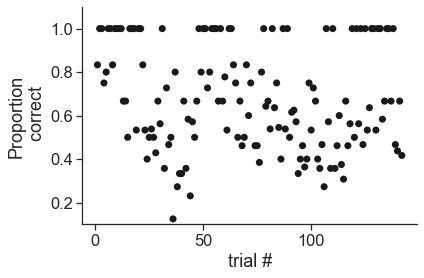

In [26]:
new_DF = DF.sort_values('date_time')

#Plot of proportion correct decisions on cumulative trials for subsequent sessions

for i in new_DF['trial_perf']:
    
    plt.scatter(np.arange(len(i)),i,color='k',s=50,edgecolors='none')
    plt.xlabel("trial #")
    plt.ylabel("Proportion\n correct")
    plt.ylim(.1,1.1)
    seaborn.despine()
    print(np.nanmean(i))
    plt.show()

In [27]:
for index in DF.index:
    print(np.nanmean((DF.score_list)[index]))

0.7804878048780488
0.6887254901960784
0.7024482109227872
0.6935146443514645
0.5642414860681114
0.698595146871009
0.7996755879967559
0.6913109756097561
0.8221302998965874
0.6594124047878128
0.7654516640253566


In [28]:
for index in DF.index:

    z = 0

    print("Mean perf in each rew location")
    for i in DF.rew_change_end[index]:
        y = np.nanmean(DF.score_list[index][z:i-1])
        z = i-1
        print(DF.rew_state[index][i-1], int(y*100))

    print("\nDoes perf imprv with succ trials with rew at same loc??")
    NM = 10 #arbitrary number of sections to take mean of
    low = 0
    arr = np.linspace(rew_change[0],rew_change_end[1],num=NM)

    for i in np.arange(NM):
        upp = arr[i]
        y = np.nanmean(DF.score_list[index][int(low):int(upp)])
        low = arr[i]
        print(int(y*100))

Mean perf in each rew location
1.0 82
7.0 63
3.0 93
5.0 76
3.0 86
1.0 76
3.0 87
1.0 90
5.0 75
3.0 88
7.0 56

Does perf imprv with succ trials with rew at same loc??
81
90
63
50
37
50
62
46
33
72
Mean perf in each rew location
1.0 59
7.0 67
3.0 89
7.0 65
3.0 85

Does perf imprv with succ trials with rew at same loc??
56
40
28
44
58
54
55
16
75
55
Mean perf in each rew location
3.0 82
7.0 61
5.0 65
3.0 90
1.0 79
5.0 61
1.0 63

Does perf imprv with succ trials with rew at same loc??
80
100
88
63
16
53
0
44
62
81
Mean perf in each rew location
7.0 58
1.0 76
7.0 65
3.0 86
1.0 84
7.0 60

Does perf imprv with succ trials with rew at same loc??
61
66
66
14
57
50
54
75
54
75
Mean perf in each rew location
3.0 78
7.0 47
1.0 68
5.0 54
7.0 49
3.0 61
7.0 50

Does perf imprv with succ trials with rew at same loc??
74
30
50
62
45
50
62
33
60
50
Mean perf in each rew location
1.0 71
3.0 83
5.0 72
7.0 58
3.0 80

Does perf imprv with succ trials with rew at same loc??
71
88
61
60
58
88
100
100
72
50
Mea

Plot perf in first set of rewards


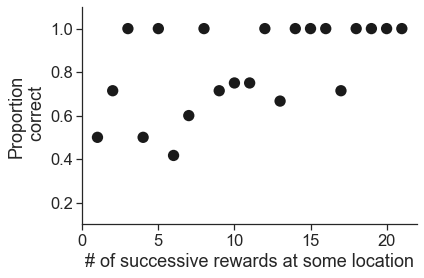

In [29]:
print("Plot perf in first set of rewards")
x = range(int(DF.trial_rew_change_end[index][0]-1))
y = DF.trial_perf[index][0:int(DF.trial_rew_change_end[index][0])-1]

plt.scatter(x, y,color='k',s=128,edgecolors='none')
plt.xlabel("# of successive rewards at some location")
plt.ylabel("Proportion\n correct")
plt.ylim(.1,1.1)
seaborn.despine()

Plot perf for successive trials at a reward location


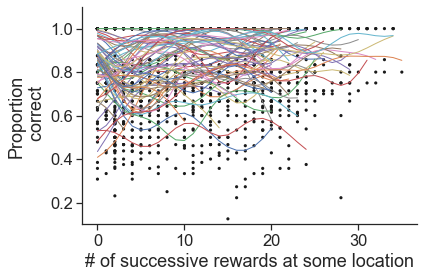

In [78]:
from scipy.ndimage import gaussian_filter1d
print("Plot perf for successive trials at a reward location")
low = 0
y_dat = pd.DataFrame()

for index in DF.index:
    y_DAT = []
    for i in np.arange(len(DF.trial_rew_change_end[index])):
        upp = int(DF.trial_rew_change_end[index][i]-1)
        x = np.arange(upp-low)
        y = DF.trial_perf[index][low:upp]
        low = upp
        y_DAT.append(y)
        plt.scatter(x, y,color='k',s=10,edgecolors='none')
        plt.xlabel("# of successive rewards at some location")
        plt.ylabel("Proportion\n correct")
        plt.ylim(0.1,1.1)
        seaborn.despine()
        plt.plot(gaussian_filter1d(y,2.25,mode='nearest'),linewidth=1)
    y_dat = y_dat.append(y_DAT)


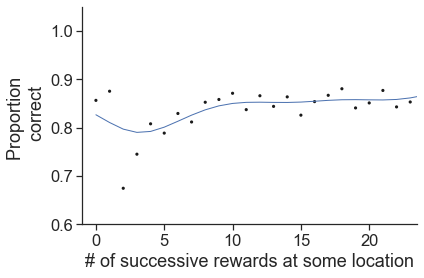

In [83]:
y = np.nanmean(y_dat, 0)
x = np.arange(len(y))
plt.scatter(x, y, color='k',s=10,edgecolors='none')
plt.xlabel("# of successive rewards at some location")
plt.ylabel("Proportion \n correct")
plt.ylim(0.6,1.05)
plt.xlim(-1,23.5)
seaborn.despine()
plt.plot(gaussian_filter1d(y,2.25,mode='nearest'),linewidth=1)

Plot perf for each section of reward location


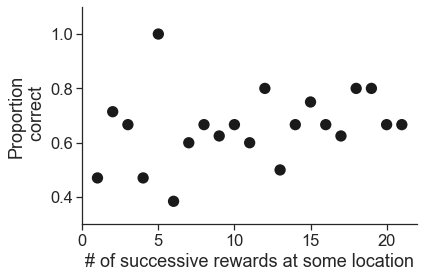

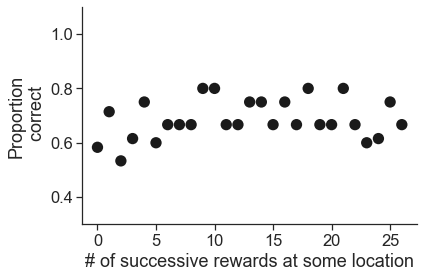

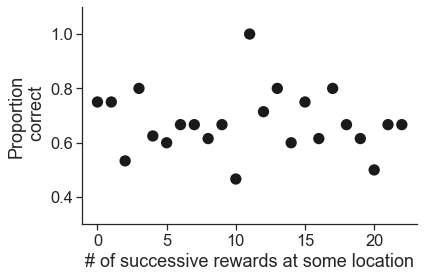

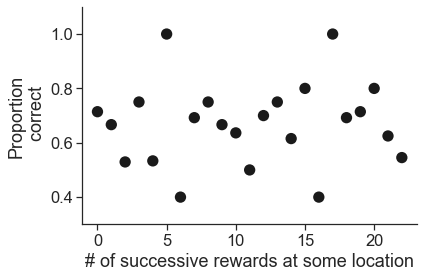

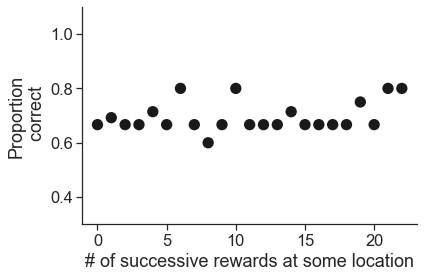

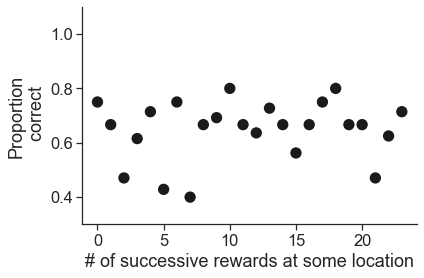

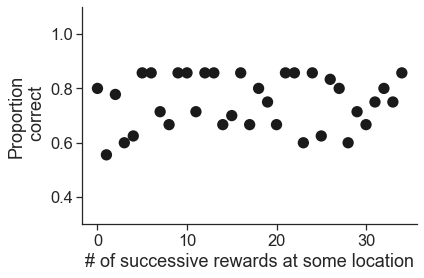

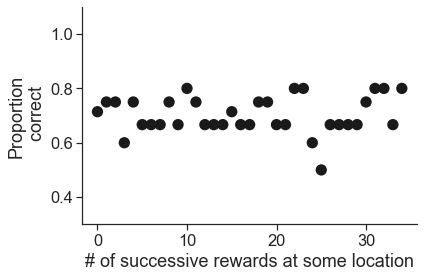

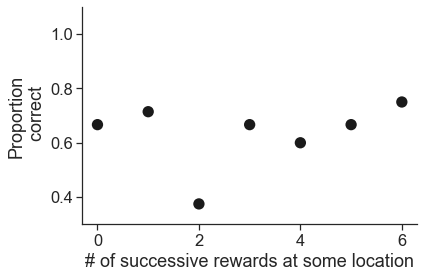

In [13]:
print("Plot perf for each section of reward location")
low = 0
for i in np.arange(len(DF.trial_rew_change_end[index])):
    upp = int(DF.trial_rew_change_end[index][i]-1)
    x = np.arange(upp-low)
    y = DF.trial_perf[index][low:upp]
    low = upp
    
    plt.scatter(x, y,color='k',s=128,edgecolors='none')
    plt.xlabel("# of successive rewards at some location")
    plt.ylabel("Proportion\n correct")
    plt.ylim(.3,1.1)
    seaborn.despine()
    plt.show()
